<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#前処理" data-toc-modified-id="前処理-1" data-vivaldi-spatnav-clickable="1">前処理</a></span><ul class="toc-item"><li><span><a href="#データセット読み込みと文字IDベクトルへの変換" data-toc-modified-id="データセット読み込みと文字IDベクトルへの変換-1.1" data-vivaldi-spatnav-clickable="1">データセット読み込みと文字IDベクトルへの変換</a></span></li><li><span><a href="#ハイパーパラメータ設定とデータ前処理" data-toc-modified-id="ハイパーパラメータ設定とデータ前処理-1.2" data-vivaldi-spatnav-clickable="1">ハイパーパラメータ設定とデータ前処理</a></span></li><li><span><a href="#model,-optimizer,-trainerインスタンス作成" data-toc-modified-id="model,-optimizer,-trainerインスタンス作成-1.3" data-vivaldi-spatnav-clickable="1">model, optimizer, trainerインスタンス作成</a></span></li></ul></li><li><span><a href="#学習実行" data-toc-modified-id="学習実行-2" data-vivaldi-spatnav-clickable="1">学習実行</a></span></li><li><span><a href="#推論" data-toc-modified-id="推論-3" data-vivaldi-spatnav-clickable="1">推論</a></span></li><li><span><a href="#結果の保存" data-toc-modified-id="結果の保存-4" data-vivaldi-spatnav-clickable="1">結果の保存</a></span></li><li><span><a href="#確信度の取得" data-toc-modified-id="確信度の取得-5" data-vivaldi-spatnav-clickable="1">確信度の取得</a></span></li></ul></div>

# seq2seqモデルの学習と結果の保存

ディレクトリ構成：  
```
./
├dataset/
│   └(読み込むCSVファイル)
├models/
│   └(モデルパラメータキャッシュファイル)
├notebooks/
│   └train_seq2seq.ipynb(このファイル)
├results/
│   └(実行結果CSVと学習曲線グラフ画像)
└src/
   ├common/
   │ └(共用クラス、関数)
   ├data/
   │ └(データ読み書き用コード)
   ├attention_layer.py
   ├attention_seq2seq.py
   ├peeky_seq2seq.py
   └seq2seq.py
```
Cupyを利用するときは、`src/common/config.py`を編集して
```python
GPU = True
```
とする

In [13]:
# 変数の全消去
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
# coding: utf-8
import sys
sys.path.append("../src")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from data.sequence import TextSequence
from common.optimizer import Adam
from common.trainer import Trainer
from seq2seq import Seq2seq, Seq2seqBiLSTM
from peeky_seq2seq import PeekySeq2seq, PeekySeq2seqBiLSTM
from attention_seq2seq import AttentionSeq2seq, AttentionSeq2seqBiLSTM

In [2]:
# matplotlibのインライン表示
%matplotlib inline
# モジュールの更新時に自動で再読み込み
%reload_ext autoreload
%autoreload 2

In [3]:
# ディレクトリパスの設定
dataset_dir =Path('../dataset')
result_dir = Path('../results')
model_dir = Path('../models')

In [4]:
# ファイルパスの設定
# 最初に全てのデータセットを読み込み、ボキャブラリ辞書を作成する
vocab_csv = [dataset_dir / "translator_gene-con_rev3.csv", dataset_dir / "translator_tori_rev2.csv"]
# source_csv = dataset_dir / "translator_gene-con_rev3.csv"
source_csv = dataset_dir / "translator_tori_rev2.csv"
dataset_name = source_csv.stem
encoding = "utf-8"

## 前処理
### データセット読み込みと文字IDベクトルへの変換

In [5]:
# 全てのデータセットを読み込み、Vocabularyを作成する
seq = TextSequence()
for path in vocab_csv:
    seq.read_csv(path)
char_to_id, id_to_char = seq.vocab

In [6]:
# 学習対象のデータセットを読み込み
seq.read_csv(source_csv)

(array([[  4,   8,  83, ...,   0,   0,   0],
        [  4,   8,  83, ...,   0,   0,   0],
        [  5,  22,  30, ...,  20,  19, 300],
        ...,
        [238, 188, 236, ...,   0,   0,   0],
        [238, 188, 236, ...,   0,   0,   0],
        [238, 188, 236, ...,   0,   0,   0]]),
 array([[  1, 248,  63, ...,   0,   0,   0],
        [  1, 248,  63, ...,   0,   0,   0],
        [  1, 298, 241, ...,   0,   0,   0],
        ...,
        [  1, 265, 238, ...,   0,   0,   0],
        [  1, 265, 238, ...,   0,   0,   0],
        [  1, 265, 238, ...,   0,   0,   0]]))

### ハイパーパラメータ設定とデータ前処理

In [7]:
# ハイパーパラメータ
vocab_size = len(char_to_id)
wordvec_size = 128
hidden_size = 128
batch_size = 64
max_epoch = 150
max_grad = 5.0

In [8]:
vocab_size

428

In [9]:
# データセット分割
x_train, x_test, t_train, t_test = seq.split_data(seed=1, test_size=0.3)

## 学習実行

In [13]:
# 保存ファイルのファイル名生成
modelname = 'PeekySeq2seq'
timestamp = datetime.now().strftime("_%y%m%d_%H%M")
save_dir = result_dir / ("survey_acc_" + dataset_name + timestamp)
os.makedirs(save_dir, exist_ok=True)

In [14]:
divisor = 5
unit = len(x_train) // divisor

Target dataset: translator_tori_rev2
Start training:
model = PeekySeq2seq
optimizer = Adam
batch size = 64
train epochs = 150
| epoch 1 | time/total 0/0[s] | loss = 6.05605
| epoch 1 | time/total 0/0[s] | train error = 1.00000
| epoch 1 | time/total 0/0[s] | test error  = 1.00000
| epoch 2 | time/total 0/0[s] | loss = 6.01042
| epoch 2 | time/total 0/0[s] | train error = 1.00000
| epoch 2 | time/total 0/0[s] | test error  = 1.00000
| epoch 3 | time/total 0/0[s] | loss = 5.94583
| epoch 3 | time/total 0/1[s] | train error = 1.00000
| epoch 3 | time/total 0/1[s] | test error  = 1.00000
| epoch 4 | time/total 0/1[s] | loss = 5.83386
| epoch 4 | time/total 0/1[s] | train error = 1.00000
| epoch 4 | time/total 0/1[s] | test error  = 1.00000
| epoch 5 | time/total 0/1[s] | loss = 5.60856
| epoch 5 | time/total 0/1[s] | train error = 1.00000
| epoch 5 | time/total 0/1[s] | test error  = 1.00000
| epoch 6 | time/total 0/2[s] | loss = 5.12723
| epoch 7 | time/total 0/2[s] | loss = 4.19006
| epo

| epoch 129 | time/total 0/27[s] | loss = 0.51063
| epoch 130 | time/total 0/27[s] | loss = 0.50721
| epoch 130 | time/total 0/27[s] | train error = 0.91579
| epoch 130 | time/total 0/27[s] | test error  = 0.96602
| epoch 131 | time/total 0/27[s] | loss = 0.46084
| epoch 132 | time/total 0/28[s] | loss = 0.46307
| epoch 133 | time/total 0/28[s] | loss = 0.42028
| epoch 134 | time/total 0/28[s] | loss = 0.42144
| epoch 135 | time/total 0/28[s] | loss = 0.40738
| epoch 136 | time/total 0/28[s] | loss = 0.42597
| epoch 137 | time/total 0/29[s] | loss = 0.40054
| epoch 138 | time/total 0/29[s] | loss = 0.39604
| epoch 139 | time/total 0/29[s] | loss = 0.34662
| epoch 140 | time/total 0/29[s] | loss = 0.39330
| epoch 140 | time/total 0/29[s] | train error = 0.92632
| epoch 140 | time/total 0/29[s] | test error  = 0.96602
| epoch 141 | time/total 0/30[s] | loss = 0.35336
| epoch 142 | time/total 0/30[s] | loss = 0.35873
| epoch 143 | time/total 0/30[s] | loss = 0.36458
| epoch 144 | time/tot

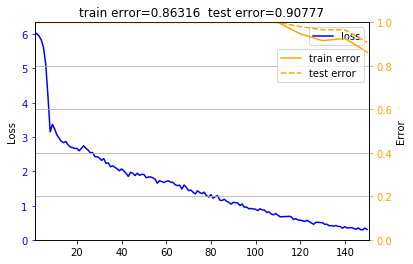

Start training:
model = PeekySeq2seq
optimizer = Adam
batch size = 64
train epochs = 150
| epoch 1 | time/total 0/0[s] | loss = 6.04359
| epoch 1 | time/total 0/0[s] | train error = 1.00000
| epoch 1 | time/total 0/0[s] | test error  = 1.00000
| epoch 2 | time/total 0/1[s] | loss = 5.95052
| epoch 2 | time/total 0/1[s] | train error = 1.00000
| epoch 2 | time/total 0/1[s] | test error  = 1.00000
| epoch 3 | time/total 0/1[s] | loss = 5.70479
| epoch 3 | time/total 0/1[s] | train error = 1.00000
| epoch 3 | time/total 0/1[s] | test error  = 1.00000
| epoch 4 | time/total 0/2[s] | loss = 4.72195
| epoch 4 | time/total 0/2[s] | train error = 1.00000
| epoch 4 | time/total 0/2[s] | test error  = 1.00000
| epoch 5 | time/total 0/2[s] | loss = 3.39759
| epoch 5 | time/total 0/3[s] | train error = 1.00000
| epoch 5 | time/total 0/3[s] | test error  = 1.00000
| epoch 6 | time/total 0/3[s] | loss = 3.16500
| epoch 7 | time/total 0/3[s] | loss = 2.82917
| epoch 8 | time/total 0/4[s] | loss = 2.9

| epoch 128 | time/total 0/50[s] | loss = 0.08774
| epoch 129 | time/total 0/50[s] | loss = 0.08649
| epoch 130 | time/total 0/50[s] | loss = 0.09171
| epoch 130 | time/total 0/51[s] | train error = 0.49474
| epoch 130 | time/total 0/51[s] | test error  = 0.69903
| epoch 131 | time/total 0/51[s] | loss = 0.08244
| epoch 132 | time/total 0/52[s] | loss = 0.07796
| epoch 133 | time/total 0/52[s] | loss = 0.08004
| epoch 134 | time/total 0/52[s] | loss = 0.07906
| epoch 135 | time/total 0/53[s] | loss = 0.07573
| epoch 136 | time/total 0/53[s] | loss = 0.07860
| epoch 137 | time/total 0/53[s] | loss = 0.07628
| epoch 138 | time/total 0/54[s] | loss = 0.08053
| epoch 139 | time/total 0/54[s] | loss = 0.07341
| epoch 140 | time/total 0/54[s] | loss = 0.07759
| epoch 140 | time/total 0/55[s] | train error = 0.46842
| epoch 140 | time/total 0/55[s] | test error  = 0.65534
| epoch 141 | time/total 0/55[s] | loss = 0.07610
| epoch 142 | time/total 0/55[s] | loss = 0.07428
| epoch 143 | time/tot

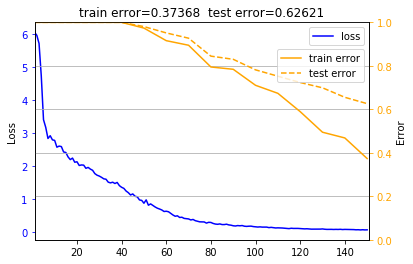

Start training:
model = PeekySeq2seq
optimizer = Adam
batch size = 64
train epochs = 150
| epoch 1 | time/total 0/0[s] | loss = 5.98440
| epoch 1 | time/total 0/0[s] | train error = 1.00000
| epoch 1 | time/total 1/1[s] | test error  = 1.00000
| epoch 2 | time/total 0/1[s] | loss = 4.79886
| epoch 2 | time/total 0/2[s] | train error = 1.00000
| epoch 2 | time/total 1/2[s] | test error  = 1.00000
| epoch 3 | time/total 0/2[s] | loss = 3.29644
| epoch 3 | time/total 0/3[s] | train error = 1.00000
| epoch 3 | time/total 1/3[s] | test error  = 1.00000
| epoch 4 | time/total 0/4[s] | loss = 2.87629
| epoch 4 | time/total 0/4[s] | train error = 1.00000
| epoch 4 | time/total 1/4[s] | test error  = 1.00000
| epoch 5 | time/total 0/5[s] | loss = 2.65102
| epoch 5 | time/total 1/5[s] | train error = 1.00000
| epoch 5 | time/total 1/5[s] | test error  = 1.00000
| epoch 6 | time/total 0/6[s] | loss = 2.52281
| epoch 7 | time/total 0/7[s] | loss = 2.28790
| epoch 8 | time/total 0/7[s] | loss = 2.2

| epoch 128 | time/total 0/99[s] | loss = 0.03702
| epoch 129 | time/total 0/100[s] | loss = 0.03658
| epoch 130 | time/total 0/100[s] | loss = 0.03497
| epoch 130 | time/total 1/101[s] | train error = 0.21754
| epoch 130 | time/total 1/101[s] | test error  = 0.48058
| epoch 131 | time/total 0/101[s] | loss = 0.03388
| epoch 132 | time/total 0/102[s] | loss = 0.03133
| epoch 133 | time/total 0/103[s] | loss = 0.03136
| epoch 134 | time/total 0/104[s] | loss = 0.03101
| epoch 135 | time/total 0/104[s] | loss = 0.02996
| epoch 136 | time/total 0/105[s] | loss = 0.02910
| epoch 137 | time/total 0/106[s] | loss = 0.02807
| epoch 138 | time/total 0/107[s] | loss = 0.02745
| epoch 139 | time/total 0/107[s] | loss = 0.02576
| epoch 140 | time/total 0/108[s] | loss = 0.02535
| epoch 140 | time/total 1/108[s] | train error = 0.16491
| epoch 140 | time/total 1/108[s] | test error  = 0.46117
| epoch 141 | time/total 0/109[s] | loss = 0.02553
| epoch 142 | time/total 0/110[s] | loss = 0.02451
| ep

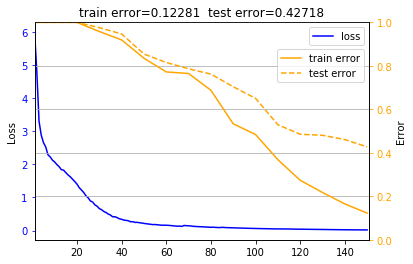

Start training:
model = PeekySeq2seq
optimizer = Adam
batch size = 64
train epochs = 150
| epoch 1 | time/total 0/0[s] | loss = 5.91167
| epoch 1 | time/total 1/1[s] | train error = 1.00000
| epoch 1 | time/total 1/1[s] | test error  = 1.00000
| epoch 2 | time/total 0/2[s] | loss = 3.90851
| epoch 2 | time/total 1/2[s] | train error = 1.00000
| epoch 2 | time/total 1/2[s] | test error  = 1.00000
| epoch 3 | time/total 0/3[s] | loss = 2.96304
| epoch 3 | time/total 1/3[s] | train error = 1.00000
| epoch 3 | time/total 1/4[s] | test error  = 1.00000
| epoch 4 | time/total 0/4[s] | loss = 2.77646
| epoch 4 | time/total 1/5[s] | train error = 1.00000
| epoch 4 | time/total 1/5[s] | test error  = 1.00000
| epoch 5 | time/total 0/6[s] | loss = 2.64552
| epoch 5 | time/total 1/6[s] | train error = 1.00000
| epoch 5 | time/total 1/6[s] | test error  = 1.00000
| epoch 6 | time/total 0/7[s] | loss = 2.46872
| epoch 7 | time/total 0/8[s] | loss = 2.26886
| epoch 8 | time/total 0/9[s] | loss = 2.1

| epoch 128 | time/total 0/121[s] | loss = 0.02150
| epoch 129 | time/total 0/122[s] | loss = 0.02121
| epoch 130 | time/total 0/123[s] | loss = 0.01993
| epoch 130 | time/total 1/124[s] | train error = 0.07368
| epoch 130 | time/total 1/124[s] | test error  = 0.36408
| epoch 131 | time/total 0/125[s] | loss = 0.01985
| epoch 132 | time/total 0/125[s] | loss = 0.01954
| epoch 133 | time/total 0/126[s] | loss = 0.02032
| epoch 134 | time/total 0/127[s] | loss = 0.01861
| epoch 135 | time/total 0/128[s] | loss = 0.01860
| epoch 136 | time/total 0/129[s] | loss = 0.01801
| epoch 137 | time/total 0/130[s] | loss = 0.01690
| epoch 138 | time/total 0/131[s] | loss = 0.01656
| epoch 139 | time/total 0/132[s] | loss = 0.01707
| epoch 140 | time/total 0/133[s] | loss = 0.01525
| epoch 140 | time/total 1/133[s] | train error = 0.07368
| epoch 140 | time/total 1/133[s] | test error  = 0.39320
| epoch 141 | time/total 0/134[s] | loss = 0.01765
| epoch 142 | time/total 0/135[s] | loss = 0.01663
| e

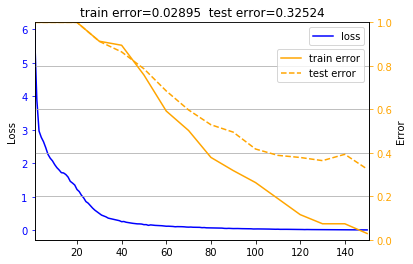

Start training:
model = PeekySeq2seq
optimizer = Adam
batch size = 64
train epochs = 150
| epoch 1 | time/total 1/1[s] | loss = 5.65821
| epoch 1 | time/total 1/1[s] | train error = 1.00000
| epoch 1 | time/total 1/1[s] | test error  = 1.00000
| epoch 2 | time/total 1/3[s] | loss = 3.13040
| epoch 2 | time/total 1/3[s] | train error = 1.00000
| epoch 2 | time/total 1/3[s] | test error  = 1.00000
| epoch 3 | time/total 1/4[s] | loss = 2.75453
| epoch 3 | time/total 1/5[s] | train error = 1.00000
| epoch 3 | time/total 1/5[s] | test error  = 1.00000
| epoch 4 | time/total 1/6[s] | loss = 2.51689
| epoch 4 | time/total 1/7[s] | train error = 1.00000
| epoch 4 | time/total 1/7[s] | test error  = 1.00000
| epoch 5 | time/total 1/8[s] | loss = 2.27912
| epoch 5 | time/total 1/9[s] | train error = 1.00000
| epoch 5 | time/total 1/9[s] | test error  = 1.00000
| epoch 6 | time/total 1/10[s] | loss = 2.14185
| epoch 7 | time/total 1/11[s] | loss = 1.97653
| epoch 8 | time/total 1/13[s] | loss = 

| epoch 127 | time/total 1/167[s] | loss = 0.01278
| epoch 128 | time/total 1/169[s] | loss = 0.01208
| epoch 129 | time/total 1/170[s] | loss = 0.01264
| epoch 130 | time/total 1/171[s] | loss = 0.01155
| epoch 130 | time/total 1/172[s] | train error = 0.07789
| epoch 130 | time/total 1/172[s] | test error  = 0.27184
| epoch 131 | time/total 1/173[s] | loss = 0.01197
| epoch 132 | time/total 1/174[s] | loss = 0.01148
| epoch 133 | time/total 1/175[s] | loss = 0.01277
| epoch 134 | time/total 1/177[s] | loss = 0.01509
| epoch 135 | time/total 1/178[s] | loss = 0.01419
| epoch 136 | time/total 1/179[s] | loss = 0.01245
| epoch 137 | time/total 1/180[s] | loss = 0.01234
| epoch 138 | time/total 1/182[s] | loss = 0.01248
| epoch 139 | time/total 1/183[s] | loss = 0.01095
| epoch 140 | time/total 1/184[s] | loss = 0.01022
| epoch 140 | time/total 1/185[s] | train error = 0.04842
| epoch 140 | time/total 1/185[s] | test error  = 0.25728
| epoch 141 | time/total 1/186[s] | loss = 0.00949
| e

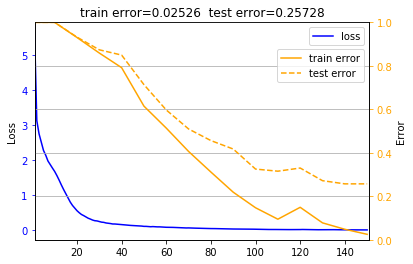

In [15]:
print("Target dataset:", dataset_name)
start_id = seq.start_id
sample_size = seq.sample_size
for i in range(1, divisor+1):
    x_train_part = x_train[:i*unit]
    t_train_part = t_train[:i*unit]
    # Model, Optimizer, Trainerの初期化
    model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
    optimizer = Adam(lr=0.002)
    trainer = Trainer(model, optimizer)
    # Train
    trainer.fit(x_train_part, t_train_part, x_test, t_test,
                max_epoch=max_epoch,
                batch_size=batch_size,
                max_grad=max_grad)
    # Inference
    print("Inference:")
    guess_train = model.generate(x_train_part, start_id, sample_size)
    guess_test = model.generate(x_test, start_id, sample_size)
    # Save result as csv
    result_train_csv = save_dir /  ("result_{}per{}_{}_{}_train.csv".format(i, divisor, dataset_name, modelname))
    result_test_csv = save_dir / ("result_{}per{}_{}_{}_test.csv".format(i, divisor, dataset_name, modelname))
    df_result_train = seq.result_to_csv(result_train_csv, x_train_part, t_train_part, guess_train, encoding=encoding)
    df_result_test = seq.result_to_csv(result_test_csv, x_test, t_test, guess_test, encoding=encoding)
    # Save result as csv as utf-8 with BOM
    result_train_csv = save_dir /  ("result_{}per{}_{}_{}_train_bom.csv".format(i, divisor, dataset_name, modelname))
    result_test_csv = save_dir / ("result_{}per{}_{}_{}_test_bom.csv".format(i, divisor, dataset_name, modelname))
    df_result_train = seq.result_to_csv(result_train_csv, x_train_part, t_train_part, guess_train, encoding="utf_8_sig")
    df_result_test = seq.result_to_csv(result_test_csv, x_test, t_test, guess_test, encoding="utf_8_sig")
    # Plot learning curve and save it as png image
    image_path = save_dir / ("result_{}per{}_{}_{}.png".format(i, divisor, dataset_name, modelname))
    trainer.plot(image_path=image_path, log_scale=False)

## ゼネコン向けデータセットの精度予測

In [28]:
from sklearn.linear_model import LinearRegression

In [74]:
x_g = np.arange(unit, unit*divisor+1, unit).reshape(-1, 1)

In [75]:
y_g = np.array([0.29794, 0.69322, 0.81711, 0.89381, 0.9174])

In [83]:
# def sigmoid(x):
#     return 1 / (1 - np.exp(-x))

In [76]:
model_g = LinearRegression(fit_intercept=True)

In [77]:
x_inv = 1 / x_g

In [79]:
model_g.fit(x_inv, y_g)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [80]:
model_g.coef_

array([-123.5215595])

In [81]:
x_hat = np.arange(100, 2000).reshape(-1, 1)

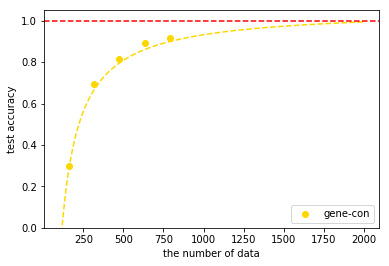

In [121]:
plt.scatter(x_g, y_g, color='gold', label='gene-con')
plt.plot(x_hat, model_g.predict(1 / x_hat)-0.025, color='gold', linestyle='--')
plt.axhline(y=1, linestyle='--', color='red')
plt.ylim((0.0, 1.05))
plt.xlabel('the number of data')
plt.ylabel('test accuracy')
plt.legend()
plt.savefig(result_dir / "predict_accuracy_gene-con.png")

## トリデータセットの精度予測

In [18]:
from sklearn.linear_model import LinearRegression

In [84]:
x_t = np.arange(unit, unit*divisor+1, unit).reshape(-1, 1)

In [85]:
y_t = np.array([0.092233, 0.373786, 0.572816, 0.674757, 0.742718])

In [83]:
# def sigmoid(x):
#     return 1 / (1 - np.exp(-x))

In [86]:
model_t = LinearRegression(fit_intercept=True)

In [60]:
x_inv = np.c_[1 / x, np.sqrt(x)]

In [87]:
x_log = np.c_[np.log(x_t), x_t]

In [88]:
model_t.fit(x_log, y_t)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [89]:
model.coef_

array([ 4.76704984e-01, -2.76778805e-04])

In [47]:
x_hat = np.arange(100, 2000).reshape(-1, 1)

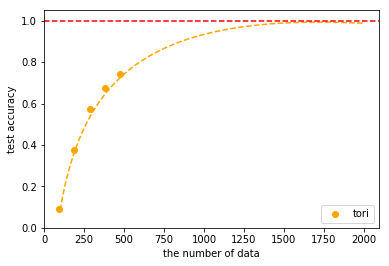

In [122]:
plt.scatter(x_t, y_t, color='orange', label='tori')
plt.plot(x_hat, model_t.predict(np.c_[np.log(x_hat), x_hat])-0.025, color='orange', linestyle='--')
plt.axhline(y=1, linestyle='--', color='red')
plt.ylim((0.0, 1.05))
plt.xlabel('the number of data')
plt.ylabel('test accuracy')
plt.legend()
plt.savefig(result_dir / "predict_accuracy_tori.png")

Text(0, 0.5, 'test accuracy')

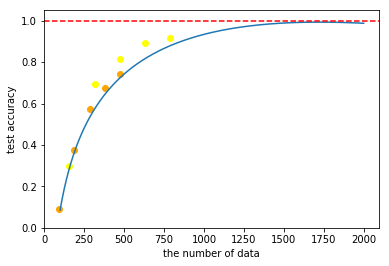

In [91]:
plt.scatter(x_t, y_t, color='orange')
plt.scatter(x_g, y_g, color='yellow')
plt.plot(x_hat, model_t.predict(np.c_[np.log(x_hat), x_hat])-0.025)
plt.axhline(y=1, linestyle='--', color='red')
plt.ylim((0.0, 1.05))
plt.xlabel('the number of data')
plt.ylabel('test accuracy')

In [92]:
x = np.r_[x_g, x_t]

In [94]:
y = np.r_[y_g, y_t]

In [95]:
x_inverse = 1 / x

In [96]:
model = LinearRegression(fit_intercept=True)

In [97]:
model.fit(x_inverse, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [98]:
model.coef_

array([-92.42496957])

In [109]:
model.predict([[1/2000]])

array([0.91707847])

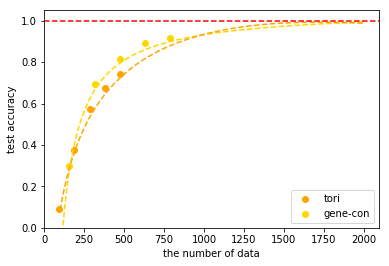

In [117]:
plt.scatter(x_t, y_t, color='orange', label='tori')
plt.scatter(x_g, y_g, color='gold', label='gene-con')
# plt.plot(x_hat, model.predict(1 / x_hat))
plt.plot(x_hat, model_g.predict(1 / x_hat)-0.025, color='gold', linestyle='--')
plt.plot(x_hat, model_t.predict(np.c_[np.log(x_hat), x_hat])-0.025, color='orange', linestyle='--')
plt.axhline(y=1, linestyle='--', color='red')
plt.ylim((0.0, 1.05))
plt.xlabel('the number of data')
plt.ylabel('test accuracy')
plt.legend()
plt.savefig(result_dir / "predict_accuracy.png")

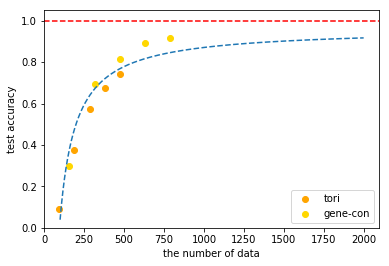

In [116]:
plt.scatter(x_t, y_t, color='orange', label='tori')
plt.scatter(x_g, y_g, color='gold', label='gene-con')
plt.plot(x_hat, model.predict(1 / x_hat), linestyle='--')
# plt.plot(x_hat, model_g.predict(1 / x_hat)-0.025, color='gold', linestyle='--')
# plt.plot(x_hat, model_t.predict(np.c_[np.log(x_hat), x_hat])-0.025, color='orange', linestyle='--')
plt.axhline(y=1, linestyle='--', color='red')
plt.ylim((0.0, 1.05))
plt.xlabel('the number of data')
plt.ylabel('test accuracy')
plt.legend()
plt.savefig(result_dir / "predict_accuracy_total.png")